<a href="https://colab.research.google.com/github/cergyqiuqiu/TBS_Projects/blob/TBS_Projects/TBS_DA_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0 - Mount googld drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/Mydrive/'

Mounted at /content/drive


# Step 0 - Import all required libraries

In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.metrics import r2_score
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Step 1 - Load (train,test) datasets from google drive

In [ ]:
url = "/content/drive/MyDrive/train.csv"
df = pd.read_csv(url)

# Step 1 - Transform data

1.   Columns to change type
  *   Data of Joining -> datetime
2.   Add more categorical columns
  *   Gender -> categorical
  *   Company type -> categorical
  *   WFH Setup Available -> categorical
3.   Check uniquety:
  *   Employee ID
4.   Check the empty column
  *   Resource Allocation: 6.1% null
  *   Mental Fatigue Score: 2117(9.3%) null
  *   Burn rate: 1124 (4.9%) null
5.   Rename the columns



In [ ]:
# 1 and 2: change type`, "Male":1})
df["WFH_cat"] = df["WFH Setup Available"].map({"No":0, "Yes":1})
df["CompanyType_cat"] = df["Company Type"].map({"Service":0, "Product":1})

df["Tenure"] = pd.to_datetime(df["Date of Joining"], format = "%Y-%m-%d").dt.dayofyear
df["Tenure"] = df["Tenure"].apply(lambda x: abs(x - df["Tenure"].max()))

In [ ]:
# 3 check uniqueness
df["Employee ID"].nunique()

22750

In [ ]:
# 4. drop unused columns
col_drop = ['Date of Joining', 'Gender', 'Company Type','WFH Setup Available']
df_clean = df.drop(labels = col_drop, axis = 1)
df_clean.dropna(axis=0, how='any', inplace=True)

newcolname ={"Employee ID": "Employee_ID", "Resource Allocation": "Resource_Allocation",
       "Mental Fatigue Score": "Mental_Fatigue_Score" , "Burn Rate": "Burn_Rate"}
df_clean.rename(columns=newcolname, inplace = True)

In [ ]:
# 5. split train, test datasets randomly
pTrain  = 0.8 # set 80% for training
features = ['Designation', 'Resource_Allocation', 'Mental_Fatigue_Score',
            'Gender_cat', 'WFH_cat','CompanyType_cat', 'Tenure']
target  = ["Burn_Rate"]
x_train,x_test, y_train,y_test = model_selection.train_test_split(df_clean[features],df_clean[target], 
                                           test_size = 1 - pTrain, random_state = 0)

df_train = pd.concat([x_train, y_train], axis =1)
df_test = pd.concat([x_test, y_test], axis =1)

# Step 2 - Data Viz

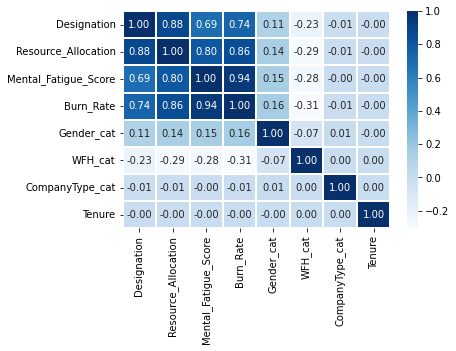

In [ ]:
# correlation matrix of features
corrMatrix = df_clean.corr()
sns.set_palette("Dark2")
sns.heatmap(corrMatrix,
            annot=True,
            cmap = "Blues",
            fmt = ".2f",
            linewidths=1)
plt.show()

In [ ]:
# Use VIF to check the multicollinearity
# vif values are higher than 4 therefore there are strong multicollinearity within the features: designation,
# resource_allocation, and mental fatigue score
df_vif = pd.DataFrame()
df_vif["features"] = features
df_vif["vif"] = [variance_inflation_factor(x_train.values, i)
                for i in range(len(features))]
print(df_vif)

               features        vif
0           Designation  20.603139
1   Resource_Allocation  37.187575
2  Mental_Fatigue_Score  20.438840
3            Gender_cat   1.920142
4               WFH_cat   1.869979
5       CompanyType_cat   1.472771
6                Tenure   3.324599


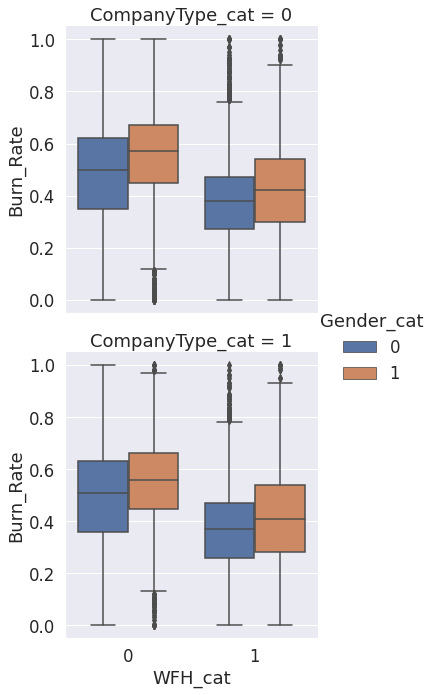

In [ ]:
# sns.set_style("white")
sns.set_palette("Blues")
sns.set(font_scale=1.5)
g = sns.catplot(x = "WFH_cat", 
        y = "Burn_Rate", 
        data = df_clean, 
        hue = "Gender_cat", 
        kind = "box",
        row = "CompanyType_cat")

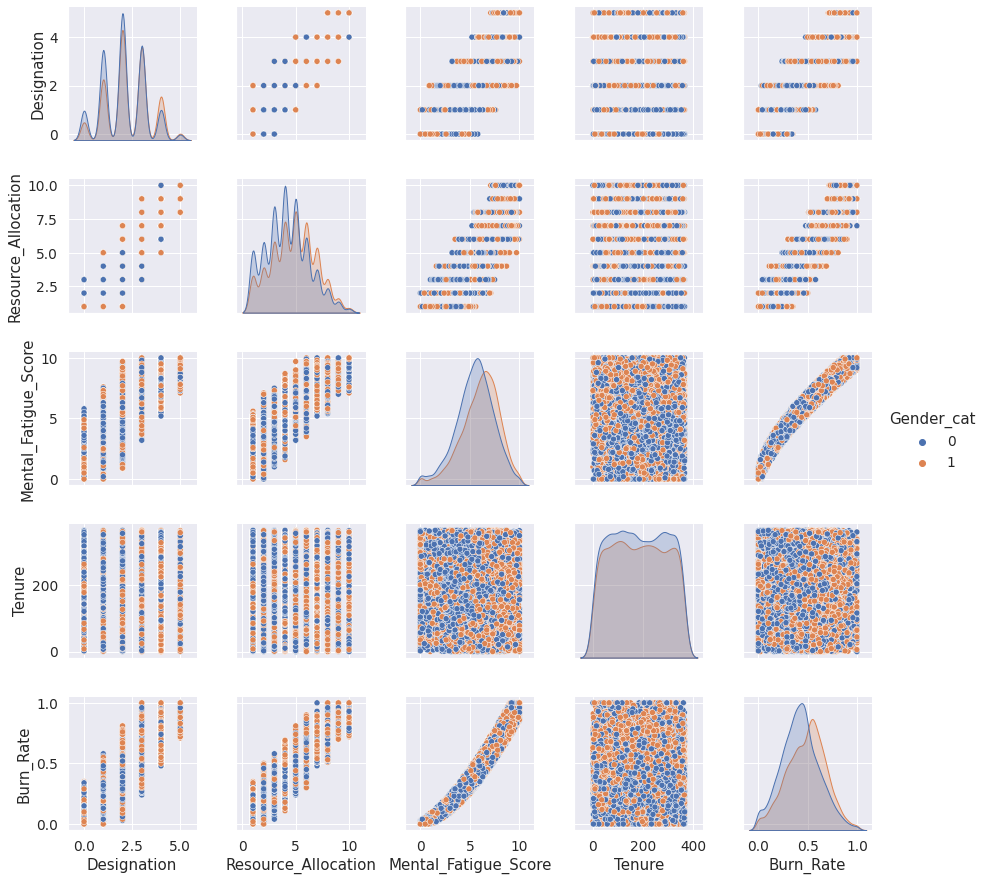

In [ ]:
sns.set_palette("Dark2")
sns.set(font_scale=1.25)
df_conti = df_clean[['Designation', 'Resource_Allocation', 'Mental_Fatigue_Score', 'Tenure', 'Burn_Rate','Gender_cat']]
sns.pairplot(df_conti, vars = df_conti.columns[:-1], hue = "Gender_cat")

# Step 3.1 - Modelling: linear regression

In [ ]:
# Apply linear regression
reg  = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)

# get the prediction results for test
df_test["Burn_Rate_pred"] = reg.predict(x_test)
df_test["Residual"] = df_test["Burn_Rate"] - df_test["Burn_Rate_pred"]
mean = df_test["Residual"].mean()
std = df_test["Residual"].std()
df_test["StdResidual"] = (df_test["Residual"] - mean)/std

# output performance summary
results = smf.ols('Burn_Rate ~ Designation + Resource_Allocation + Mental_Fatigue_Score \
                    + Gender_cat + WFH_cat + CompanyType_cat + Tenure', data = df_train).fit()
print(results.summary())

print(r2_score(y_test, y_pred))

                            OLS Regression Results                            
Dep. Variable:              Burn_Rate   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 2.478e+04
Date:                Fri, 18 Mar 2022   Prob (F-statistic):               0.00
Time:                        07:42:06   Log-Likelihood:                 21823.
No. Observations:               14872   AIC:                        -4.363e+04
Df Residuals:                   14864   BIC:                        -4.357e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0849 

Text(0.5, 1.0, 'Predict Error Residual distribution')

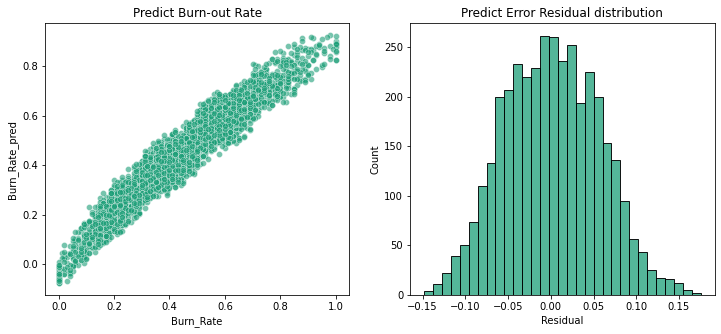

In [ ]:
# plot seaborn
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))
# sns.relplot(ax=axes[0], x = "Burn_Rate", y = "Burn_Rate_pred", data = df_test, kind = "scatter")
sns.scatterplot(ax=axes[0], 
                x = "Burn_Rate", 
                y = "Burn_Rate_pred", 
                data = df_test,
                alpha = 0.6)
sns.histplot(ax=axes[1], x = "Residual", data = df_test)

axes[0].set_title("Predict Burn-out Rate")
axes[1].set_title("Predict Error Residual distribution")

# Step 3.2 - L1 regularization

In [ ]:
# Linear regression + Lasso regulation
model_l1_cv = linear_model.LassoCV(cv = 5, random_state= 0)
reg_l1_cv = model_l1_cv.fit(x_train, y_train)
y_pred_l1_cv = reg_l1_cv.predict(x_test)
print(reg_l1_cv.coef_)
print(reg_l1_cv.intercept_)
print(r2_score(y_test, y_pred_l1_cv))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[-2.93981653e-03  2.77168940e-02  7.40062141e-02  2.95339509e-03
 -1.00644815e-02 -0.00000000e+00 -5.34859283e-07]
-0.0858346501497656
0.9188613174296354


# Step 3.3 - L2 regularization

In [ ]:
# Try Linear regression L2
model_l2_cv = linear_model.RidgeCV(alphas = np.logspace(-10,5,10))
reg_l2_cv = model_l2_cv.fit(x_train, y_train)
y_pred_l2_cv = reg_l2_cv.predict(x_test)
print(reg_l2_cv.coef_)
print(reg_l2_cv.intercept_)
print(r2_score(y_test, y_pred_l2_cv))

[[-4.65518360e-03  2.85268733e-02  7.39605583e-02  4.29359933e-03
  -1.14039549e-02 -1.34846881e-03 -4.75614797e-07]]
[-0.08493046]
0.9188894084773802


# Step 3.4 - PCA

          PC1       PC2       PC3       PC4
0  170.008508  5.814965 -0.444167 -0.103287
1   29.007651 -6.411065 -2.232597  0.079938
2   53.007916 -2.725605 -1.162649 -0.626038
3  -72.992205 -5.165514  0.111732  1.120565
4  135.008210  0.687249  0.329230  0.269141
[9.99107832e-01 7.28567500e-04 8.10085047e-05 2.27217436e-05]
0.9183779051629462


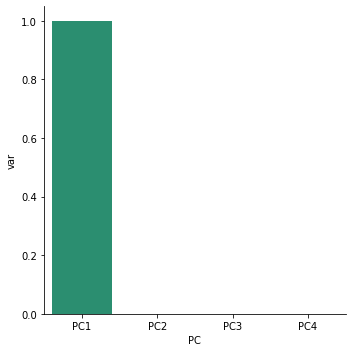

In [ ]:
# PCA + linear regression
pca = PCA(n_components=4)
pc = pca.fit_transform(x_train)
pc_test = pca.transform(x_test)
df_pc = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3', 'PC4'])
print(df_pc.head())
print(pca.explained_variance_ratio_)
df_pc_exp = pd.DataFrame({'var': pca.explained_variance_ratio_,
                          'PC' : ['PC1', 'PC2', 'PC3', 'PC4']})
sns.catplot(x = "PC", y = "var", data = df_pc_exp, kind = "bar")

reg_pca = LinearRegression().fit(pc, y_train["Burn_Rate"])

y_pred_pca = reg_pca.predict(pc_test)

print(r2_score(y_test, y_pred_pca))